In [26]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
import wandb

random.seed(27)
np.random.seed(27)
plt.style.use('ggplot')

## Dataset

In [31]:
# Pick dataset
ds = "mnist"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
if ds == "cifar10":
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    X_train = train_ds.data.astype(np.float32) / 255.0  # normalize manually
    y_train = np.array(train_ds.targets, dtype=np.int64)

    X_test  = test_ds.data.astype(np.float32) / 255.0
    y_test  = np.array(test_ds.targets, dtype=np.int64)

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test  = X_test.reshape(X_test.shape[0], -1)

    # Flatten
    X_train = X_train.reshape(-1, np.prod(X_train.shape[1:]))
    X_test = X_test.reshape(-1, np.prod(X_test.shape[1:]))

    print("Train shape:", X_train.shape, y_train.shape)
    print("Test shape:", X_test.shape, y_test.shape)
elif ds == "mnist":
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=None)
    mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=None)

    X_train = mnist_train.data.to(torch.float32).numpy()
    y_train = mnist_train.targets.to(torch.int64).numpy()

    X_test  = mnist_test.data.to(torch.float32).numpy()
    y_test  = mnist_test.targets.to(torch.int64).numpy()

    # Normalize the pixel values (important for neural nets)
    X_train /= 255.0
    X_test /= 255.0

    # Flatten
    X_train = X_train.reshape(-1, np.prod(X_train.shape[1:]))
    X_test = X_test.reshape(-1, np.prod(X_test.shape[1:]))

    print("Train shape:", X_train.shape, y_train.shape)
    print("Test shape:", X_test.shape, y_test.shape)

Train shape: (60000, 784) (60000,)
Test shape: (10000, 784) (10000,)


In [34]:
def one_hot_encode(y, num_classes=10):
    y_encoded = np.zeros((num_classes, y.size))
    y_encoded[y, np.arange(y.size)] = 1
    return y_encoded

Y_train = one_hot_encode(y_train, 10)  # (10, 60000)
Y_test  = one_hot_encode(y_test, 10)   # (10, 10000)

# --------------------------------------------------
# Quick check
# --------------------------------------------------
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test: ", X_test.shape,  "Y_test: ",  Y_test.shape)

X_train: (60000, 784) Y_train: (10, 60000)
X_test:  (10000, 784) Y_test:  (10, 10000)


Since we're dealing with feed forward neural networks (and e.g., not CNNs), we need to flatten the image-tensor for each input. E.g., for a $4 \times 4$ grayscale image tensor, we flatten it as such:
$$
x_i =
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix} \in \mathbb{R}^{4 \times 4}
, \qquad
\mathrm{flatten}(x_i) =
\begin{bmatrix}
1 & 2 & 3 & 4 &
5 & 6 & 7 & 8 &
9 & 10 & 11 & 12 &
13 & 14 & 15 & 16
\end{bmatrix}^T \in \mathbb{R}^{16 \times 1}
$$

## Feedforward Neural Network

Given input $\bm{x} \in \mathbb{R}^D$ and outputs $\bm{y} \in \mathbb{R}^K$:
$$
\bm{x} = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_D
\end{bmatrix}
, \qquad
\bm{y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_O
\end{bmatrix}
$$

we can construct a feed-forward network using basis functions. We can write it as the following recurrence relation.

The first layer is:
$$
a_j^{(1)} = \sum^{D}_{i=1} w_{j,i}^{(1)} x_i + w_{j,0}^{(1)}, \qquad z_i^{(0)} = x_i
$$

where $i = 1, \dots, D$ and $j = 1, \dots, D_{1}$, we are essentially just making $D_{1}$ linear combinations of the inputs $x_1, \dots, x_D$ with $w_{j,i}^{(1)}$ and $w_{j,0}^{(1)}$, which are the weights and biases of the first layer. Here $z_i^{(0)}$ are the hidden units, which in the first layer is just the input.

The first layer is then connected to the second layer:
$$
a_k^{(2)} = \sum^{D_{1}}_{j=1} w_{k,j}^{(2)} z_j^{(1)} + w_{k,0}^{(2)}, \qquad z_j^{(1)} = h\left( a_j^{(1)} \right)
$$

with $k = 1, \dots, D_{2}$.

Note here that we use an activation function $h(\cdot)$ to non-linearize the pre-activations so that they can perform smooth fits of points. These activation functions need to be properly differentiable, so that they can be used in a forward- and backward-propagation chain. That is, both $h(\cdot) = \mathrm{forward}(\cdot)$ and $h'(\cdot) = \mathrm{backward}(\cdot)$ need to be properly defined.

We then have the necessary prerequisites to generalize the recurrence relation, so for layers $l = 1, 2, \dots, L$:

$$
a_\alpha^{(l)} = \sum^{D_{l-1}}_{\beta=1} w_{\alpha, \beta}^{(l)} z_\beta^{(l-1)} + w_{\alpha, 0}^{(l)}, \qquad z_\beta^{(l-1)} = h\left( a_\beta^{(l-1)} \right)
$$

where $w_{\alpha,\beta}^{(l)}$ are the weights and $w^{(l)}_{\alpha, 0}$ are the biases of the $l$'th layer.

Note here that all $a_\alpha^{(l)}$ are known as pre-activations and $z_\beta^{(l)}$ are known as post-activations.

Finally, we have the output units:
$$
y_o(\bm{x}, \bm{w}) = z_r^{(L)} = h_L\left(a_r^{(L)} \right) = f\left(a_r^{(L)} \right)
$$

in which the "activation" function is changed into a prediction function $f$ to get probabilities $p_o \in [0, 1]$. Most often softmax is used.

All of this can also be written in vector/matrix notation, which is the kind that we will use in this project (since the vectorization of operations is more efficient):
$$
\bm{X} =
\begin{bmatrix}
\vert & \vert & & \vert\\
\bm{x}^{(1)} & \bm{x}^{(2)} & \dots & \bm{x}^{(m)} \\
\vert & \vert & & \vert
\end{bmatrix} \in \mathbb{R}^{D \times m}
$$
where $m$ is number of samples and $D$ is input dimensionality.

For a network with $L$ layers $l = 1, 2, \dots, L$, we have the recurrence relation:
$$
\bm{A}^{1} = \bm{W}^{(1)} \bm{X} + \bm{b}^{(1)}, \qquad \bm{Z}^{(0)} = \bm{X}, \qquad \bm{W}^{(1)} \in \mathbb{R}^{D_1 \times D}, \qquad \bm{b}^{(1)} \in \mathbb{R}^{D_1}
$$

$$
\bm{A}^{2} = \bm{W}^{(2)} \bm{Z}^{(1)} + \bm{b}^{(2)}, \qquad \bm{Z}^{(1)} = h\left( \bm{A}^1 \right), \qquad \bm{W}^{(2)} \in \mathbb{R}^{D_2 \times D_1}, \qquad \bm{b}^{(2)} \in \mathbb{R}^{D_2}
$$

$$
\bm{A}^{(l)} = \bm{W}^{(l)} \bm{Z}^{(l-1)} + \bm{b}^{(l)}, \quad \bm{Z}^{(l-1)} = h\left( \bm{A}^{l-1} \right), \qquad \bm{W}^{(l)} \in \mathbb{R}^{D_l \times D_{l-1}}, \qquad \bm{b}^{(l)} \in \mathbb{R}^{D_l}
$$

$$
\bm{Y}(\bm{x}, \bm{w}) = \bm{Z}^{(L)} = f \left( \bm{A}^L \right)
$$

where the bias vector $\bm{b}^{(l)}$ is broadcast across all $l$ units.

### Activation functions

Programatically, we just need activation functions to support both forward and backward propagation for a layer. Forward propagation simply uses the base function (non-derivative). Backward propagation uses the first order derivative of the function itself. As discussed previously:
$$
h(x) = \mathrm{forward}(x), \qquad h'(x) = \mathrm{backward}(x)
$$

For example, the ReLU activation function:
$$
\mathrm{ReLU}(x) = \max(0,x) =
\begin{cases}
0 & \text{if } x \leq 0 \\
x & \text{if } x > 0
\end{cases}
, \qquad

\mathrm{ReLU}'(x) =
\begin{cases}
0 & \text{if } x \leq 0 \\
1 & \text{if } x > 0
\end{cases}
$$

so we simply just construct an `Activation` function class with `forward` and `backward` methods.

In [ ]:
class Activation:
    """Base class for all activation functions."""
    def forward(self, Z):
        raise NotImplementedError
    
    def backward(self, dA, Z):
        raise NotImplementedError

class ReLU(Activation):
    def forward(self, Z):
        self.Z = Z
        return np.maximum(0, Z)
    
    def backward(self, dA):
        return dA * (self.Z > 0).astype(float) # True = 1, False = 0

class Sigmoid(Activation):
    def forward(self, Z):
        self.Z = Z
        self.A = 1 / (1 + np.exp(-Z))
        return self.A
    
    def backward(self, dA):
        return dA * self.A * (1 - self.A)

class Tanh(Activation):
    def forward(self, Z):
        self.Z = Z
        self.A = np.tanh(Z)
        return self.A
    
    def backward(self, dA):
        return dA * (1 - self.A**2)

class Identity(Activation):
    def forward(self, Z):
        self.Z = Z
        return Z
    
    def backward(self, dA):
        return dA

# Note: softmax is technically not an activation function, but we disguise it as one for easier implementation
class Softmax:
    def forward(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        self.A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
        return self.A
    
    def backward(self, dA):
        # Usually handled with cross-entropy; raise if used alone
        raise NotImplementedError("Softmax derivative should be combined with cross-entropy.")

### Initializer

An `Initializer` class to initialize parameters $\bm{\Omega}^{(l)} = \{ \bm{W}^{(l)}, \bm{b}^{(l)} \}$ so that activations maintain stable variance across layers.

The key idea (Bishop, UDL book) is that if weights are too large, variance explodes and if it's too small, variance shrinks, so we try to scale parameters such that:
$$
\mathrm{Var}\left(\bm{A}^{(l)} \right) \approx \mathrm{Var}\left(\bm{Z}^{(l-1)} \right)
$$

Below we will exemplify this through He initialization using the ReLU activation function ($h(\cdot) = \mathrm{ReLU}(\cdot)$).

Assuming biases $b_{\alpha}^{(l)} = w^{(l)}_{\alpha, 0}$ are initialized to zero and weights and inputs are i.i.d., and independent of one another.

#### Variance of a single pre-activation
Consider one hidden unit $\alpha$ in layer $l$:
$$
a^{(l)} = \sum^{D_{l-1}}_{\beta = 1} w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} + b_{\alpha}^{(l)}
$$

Since $b_{\alpha}^{(l)} = 0$:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = \mathrm{Var}\left( \sum^{D_{l-1}}_{\beta = 1} w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} \right) 
$$

Using that $w^{(l)}_{\alpha, \beta}$ and $z^{(l-1)}_{\beta}$ are independent and also i.i.d. for all $\beta$:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = \sum^{D_{l-1}}_{\beta = 1} \mathrm{Var}\left( w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} \right) = D_{l-1} \mathrm{Var}\left( w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} \right) 
$$

For two independent random variables:
$$
\mathrm{Var}(X Y) = \mathrm{Var}(X) \mathrm{Var}(Y) + (\mathbb{E}[X])^2 \mathrm{Var}(Y) + (\mathbb{E}[Y])^2 \mathrm{Var}(X)
$$

Applying this, we get:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \left( \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \mathrm{Var}\left( z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ w_{\alpha, \beta}^{(l)} \right] \right)^2 \cdot \mathrm{Var}\left(z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right] \right)^2 \cdot \mathrm{Var}\left(w_{\alpha, \beta}^{(l)} \right) \right)
$$

Since weights are initialized with $w \sim \mathcal{N}(0, \mathrm{Var}(w))$, we have $\mathbb{E}\left[ w_{\alpha, \beta}^{(l)} \right] = 0$, so the above is reduced to:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \left( \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \mathrm{Var}\left( z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right] \right)^2 \cdot \mathrm{Var}\left(w_{\alpha, \beta}^{(l)} \right) \right)
$$

Factor out $\mathrm{Var}\left(w_{\alpha, \beta}^{(l)} \right)$:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left( \mathrm{Var}\left( z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right] \right)^2 \right)
$$

Using the definition of variance we have $\mathrm{Var}(X) + \left(\mathbb{E}\left[ X \right] \right)^2 = \mathbb{E}\left[X^2 \right]$. We can apply this:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right]^2 \right)
$$

#### Expected squared expectation for ReLU
Because $a^{(l-1)}_{\beta} \sim \mathcal{N}\left(0, \mathrm{Var}\left( a^{(l-1)}_{\beta} \right) \right)$ and $z_\beta^{(l-1)} = \mathrm{ReLU}\left( a^{(l-1)}_{\beta} \right)$, we obtain:
$$
\begin{align*}
\mathbb{E}\left[\left(z_\beta^{(l-1)} \right)^2 \right] &= \int^{\infty}_{-\infty} \left( \mathrm{ReLU}\left( a^{(l-1)}_{\beta} \right) \right)^2 \cdot f_{a^{(l-1)}_{\beta}} \left( a_\beta^{(l-1)} \right) \, \mathrm{d}\left(a_\beta^{(l-1)} \right) \\
&= \int^{\infty}_{0} \left( a^{(l-1)}_{\beta} \right)^2 \cdot f_{a^{(l-1)}_{\beta}} \left( a_\beta^{(l-1)} \right) \, \mathrm{d}\left(a_\beta^{(l-1)} \right) \qquad \text{since } \mathrm{ReLU} = 0 \text{ for } a < 0 \\
\end{align*}
$$

Using symmetry:
$$
\begin{align*}
\mathbb{E}\left[\left(z_\beta^{(l-1)} \right)^2 \right] &= \frac{1}{2} \int^{\infty}_{-\infty} \left( a^{(l-1)}_{\beta} \right)^2 \cdot f_{a^{(l-1)}_{\beta}} \left( a_\beta^{(l-1)} \right) \, \mathrm{d}\left(a_\beta^{(l-1)} \right) \\
&= \frac{1}{2} \mathbb{E}\left[ \left( a^{(l-1)}_{\beta} \right)^2 \right] \\
&= \frac{1}{2} \mathrm{Var}\left( a^{(l-1)}_{\beta} \right) \qquad \text{since zero mean} 
\end{align*}
$$

So for ReLU, we have:
$$
\mathrm{Var}\left( z^{(l-1)}_{\beta} \right) = \mathbb{E}\left[\left(z_\beta^{(l-1)} \right)^2 \right] = \frac{1}{2} \mathrm{Var}\left( z^{(l-1)}_{\beta} \right)
$$

Returning to the variance of the pre-activation:
$$
\begin{align*}
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) &= D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right]^2 \right) \\
&= D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left( \frac{1}{2} \mathrm{Var}\left( z^{(l-1)}_{\beta} \right) \right) \\
&= \frac{1}{2} D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \mathrm{Var}\left( z^{(l-1)}_{\beta} \right)
\end{align*}
$$

#### Variance across all layers
We relate this to the recurrence relation defined earlier. Recall that $\bm{Z}^{(0)} = \bm{X}$, then for $l = 1, \dots, L$:
$$
\mathrm{Var}\left( \bm{A}^{(l)} \right) = D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \mathrm{Var}\left( \bm{Z}^{(l-1)} \right)
$$

and for ReLU we have $\mathrm{Var}\left( \bm{Z}^{(l)} \right) = \frac{1}{2} \mathrm{Var}\left( \bm{A}^{(l)} \right)$:
$$
\mathrm{Var}\left( \bm{A}^{(l)} \right) = D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \mathrm{Var}\left( \bm{Z}^{(l-1)} \right)
$$

so recursively, for the last layer:
$$
\mathrm{Var}\left( \bm{A}^{(L)} \right) = \mathrm{Var}\left( \bm{Z}^{(0)} \right) \prod^{L}_{l=1} \left( \frac{1}{2} D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \right)
$$

#### Weight initialization
To maintain stable variance while propagating layers we must have:
$$
\frac{1}{2} D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \approx 1
$$

Solving for variance:
$$
\mathrm{Var}\left( \bm{W}^{(l)} \right) \approx \frac{2}{D_{l-1}}
$$

Inserting this into the distribution:
$$
W^{(l)}_{\alpha, \beta} \sim \mathcal{N}\left( 0, \frac{2}{D_{l-1}} \right)
$$

which gives He initialization. 

Note here that $D_{l-1}$ is equivalent to `n_in`.

In [ ]:
class Initializer:
    """Base class for all weight initializers."""
    def init_weights(self, n_in, n_out): # W^[l]
        raise NotImplementedError

    def init_bias(self, n_out): # b^[l]
        raise NotImplementedError

class ConstantInitializer(Initializer):
    def __init__(self, weight=1.0, bias=0.0):
        self.weight = weight
        self.bias = bias

    def init_weights(self, n_in, n_out):
        return np.full((n_in, n_out), self.weight)

    def init_bias(self, n_out):
        return np.full((n_out,), self.bias)

class NormalInitializer(Initializer):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    
    def init_weights(self, n_in, n_out):
        return np.random.normal(self.mean, self.std, (n_out, n_in))
    
    def init_bias(self, n_out):
        return np.zeros((n_out, 1))

# Specifically for ReLU activation function
class HeInitializer(Initializer):
    def init_weights(self, n_in, n_out):
        std = np.sqrt(2 / n_in)
        return np.random.normal(0, std, (n_out, n_in))
    
    def init_bias(self, n_out):
        return np.zeros((n_out, 1))

### Layers

We now construct a `Layer` class to handle all forward and backward propagation. We then create a `DenseLayer` which is synonymous with a fully connected layer, i.e. a layer in which every neuron (hidden unit) in layer $l$ is connected with every neuron in $l-1$.

Here we also make use of the `Initializer` and `Activation` classes we made. Furthermore, we have also introduced L2 regularization to encourage smoother weights (UDL book).

In [ ]:
class Layer:
    def forward(self, A_prev): # A^[l-1]
        raise NotImplementedError

    def backward(self, dA, learning_rate): # dA^[l]
        raise NotImplementedError

class DenseLayer(Layer):
    def __init__(
        self,
        n_in:int,
        n_out:int,
        activation:Activation,
        initializer:Initializer=None,
        l2_coeff:float=0.0
    ):
        # Initialize weights and bias
        self.initializer = initializer
        self.W = self.initializer.init_weights(n_in, n_out) # W^[l]
        self.b = self.initializer.init_bias(n_out)          # b^[l]
        self.activation = activation
        self.l2_coeff = l2_coeff # lambda

        # Caching during forward/backward
        self.Z = None
        self.A_prev = None
    
    def __repr__(self):
        act_name = self.activation.__class__.__name__
        return (
            f"DenseLayer({self.W.shape[1]} -> {self.W.shape[0]}, Activation={act_name})\n"
            f"Weights shape: {self.W.shape}, min: {self.W.min():.4f}, max: {self.W.max():.4f}, mean: {self.W.mean():.4f}\n"
            f"Biases shape: {self.b.shape}, min: {self.b.min():.4f}, max: {self.b.max():.4f}, mean: {self.b.mean():.4f}"
        )
    
    def forward(self, A_prev):
        # Save for backward
        self.A_prev = A_prev                     # (n_in, m)
        self.Z = np.dot(self.W, A_prev) + self.b # (n_out, m)

        # Return activation
        return self.activation.forward(self.Z)
    
    def backward(self, dA):
        m = self.A_prev.shape[1] # batch size

        if isinstance(self.activation, Softmax):
            dZ = dA # G
        else:
            dZ = self.activation.backward(dA)

        # Gradients
        dW = (1/m) * np.dot(dZ, self.A_prev.T) + (self.l2_coeff/m) * self.W # regularization applied only to weights
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        # Gradient for previous layer
        dA_prev = np.dot(self.W.T, dZ)
        
        return dA_prev, dW, db

Quick test, probability distribution:

In [ ]:
layer1 = DenseLayer(
    n_in=X_train.shape[1],
    n_out=15,
    activation=ReLU(),
    initializer=HeInitializer()
)
output_layer = DenseLayer(
    n_in=15,
    n_out=10,
    activation=Softmax(),
    initializer=NormalInitializer()
)

A1 = layer1.forward(X_train.T)      # ReLU
A2 = output_layer.forward(layer1.Z) # SoftMax

sample_probs = A2[:, 0]      # first sample
print(sample_probs)
print(sum(sample_probs))     # should be 1.0

[0.1146046  0.08363436 0.08665764 0.1078883  0.11742199 0.07201162
 0.06545692 0.11509488 0.10622731 0.13100236]
0.9999999999999999


In [15]:
print(layer1)

DenseLayer(784 -> 15, Activation=ReLU)
Weights shape: (15, 784), min: -0.1819, max: 0.1935, mean: -0.0003
Biases shape: (15, 1), min: 0.0000, max: 0.0000, mean: 0.0000


### Loss

Here we have a class for `Loss` functions. We've implemented `CrossEntropyLoss` for multi-class classification and `MSELoss` for regression. Again, we follow the same design-paradigm with `forward` and `backward` class methods.

We can derive the Cross Entropy loss function as follows. We have a training set $\mathcal{D} = \{ (\bm{x}_n, \bm{t}_n) : n = 1, \dots, N \}$. The loss (or error) is then a measure of how far $\bm{y}(\bm{x}, \bm{w})$ is from the target data.

#### Softmax
For a minibatch of size $m$, the final pre-activations are:
$$
\bm{A}^{(L)} \in \mathbb{R}^{K \times m}
$$

where each column $\bm{a}^{(L)}_n$ is the $K$-vector of logits for example $n$.

In case we wanted to use the whole dataset, we'd set $m=N$.

We define the softmax output:
$$
\bm{Y}(\bm{x}, \bm{w}) = \mathrm{softmax}\left( \bm{A}^{(L)} \right), \qquad \bm{Y}_{k,n} = \frac{\exp\left( A^{(L)}_{k,n} \right)}{\sum^{K}_{j=1} \exp\left( A^{(L)}_{j,n} \right)}
$$

Targets for the minibatch are then encoded as one-hot (or probabilities) in:
$$
\bm{T} \in \mathbb{R}^{K \times m}, \qquad T_{k,n} \in \{ 0, 1 \}, \qquad \sum^{K}_{k=1} T_{k,n} = 1
$$

#### Cross Entropy loss
The likelihood for one example $n$ under the model is:
$$
P(\bm{t}_n \mid \bm{x}_n, \bm{w}) = \prod^{K}_{k=1} \left[ \bm{Y}_k(\bm{x}_n) \right]^{T_{k,n}}
$$

Using negative log likelihood, we get the loss (for the whole minibatch):
$$
L(\bm{w}) = -\log\left( \prod^{m}_{n=1} \left( \prod^{K}_{k=1} \left[ \bm{Y}_k(\bm{x}_n) \right]^{T_{k,n}} \right) \right) = - \sum^{m}_{n=1} \sum^{K}_{k=1} T_{k,n} \log\left( \bm{Y}_{k,n} \right)
$$

The batched-average loss:
$$
L(\bm{w}) = - \frac{1}{m} \sum^{m}_{n=1} \sum^{K}_{k=1} T_{k,n} \log\left( \bm{Y}_{k,n} \right)
$$

#### Derivative w.r.t. logits
We need the gradient $\frac{\partial L}{\partial A^{(L)}_{j,n}}$ for a single sample $n$. First we calculate the loss:
$$
L^{(n)} = -\sum^{K}_{k=1} t_k \log(y_k), \qquad y_k = \frac{\exp\left( A^{(L)}_{k,n} \right)}{\sum_{j} \exp\left( A^{(L)}_{j,n} \right)}
$$

We get the result:
$$
\frac{\partial L}{\partial A^{(L)}_{j,n}} = Y_{j,n} - T_{j,n}
$$

for each class index $j$.

Since we do this vectorized, we have gradient:
$$
\bm{G} := \frac{\partial L}{\partial \bm{A}^{(L)}} \in \mathbb{R}^{K \times m}
$$

and elementwise we have:
$$
\bm{G} = \frac{1}{m} (\bm{Y} - \bm{T})
$$

#### Gradients for final layer
The final layer will output $\bm{A}^{(L)} = \bm{W}^{(L)} \bm{Z}^{(L-1)} + \bm{b}^{(L)}$ where $\bm{Z}^{(L-1)} \in \mathbb{R}^{D_{L-1} \times m}$ are activations from the previous layer.

Using $\bm{G} = \frac{\partial L}{\partial \bm{A}^{(L)}} = \frac{1}{m} (\bm{Y} - \bm{T})$, the gradients we get are:
$$
\frac{\partial L}{\partial \bm{W}^{(L)}} = \bm{G} \left(\bm{Z}^{(L-1)}\right)^T \in \mathbb{R}^{K \times D_{L-1}}, \qquad \frac{\partial L}{\partial \bm{b}^{(L)}} = \bm{G} \bm{1}_m = \frac{1}{m} \sum^{m}_{n=1} (\bm{Y}_{:,n} - \bm{T}_{:,n}) \in \mathbb{R}^{K}
$$

If L2 regularization is included, simply add $\lambda \bm{W}^{(L)}$ to $\frac{\partial L}{\partial \bm{W}^{(L)}}$.

The gradient we pass to the previous layer is then:
$$
\frac{\partial L}{\partial \bm{Z}^{(L-1)}} = \left( \bm{W}^{(L)} \right)^T \bm{G}
$$

In [ ]:
class Loss:
    def forward(self, A, Y):
        raise NotImplementedError
    
    def backward(self, A, Y):
        raise NotImplementedError

class CrossEntropyLoss(Loss):
    def forward(self, A, Y):
        m = Y.shape[1]
        loss = -np.sum(Y * np.log(A + 1e-8)) / m
        return loss
    
    def backward(self, A, Y):
        return A - Y  # G, derivative when combined with softmax

class MSELoss(Loss):
    def forward(self, A, Y):
        m = Y.shape[1]
        return np.sum((A - Y)**2) / (2 * m)
    
    def backward(self, A, Y):
        m = Y.shape[1]
        return (A - Y) / m

### Optimizer

The goal of an `Optimizer` is to find the parameters that minimize the loss. It uses the gradients with respect to the parameters $\bm{W}$ and $\bm{b}$ to do so. At each iteration it updates the weights wrt. a defined magnitude $\alpha$, that decides how much the parameters will change, and the gradients:
$$
\bm{W} \leftarrow \bm{W} - \alpha_{\bm{W}} \cdot \frac{\partial L}{\partial \bm{W}}, \qquad \bm{b} \leftarrow \bm{b} - \alpha_{\bm{b}} \cdot \frac{\partial L}{\partial \bm{b}}
$$

Here we implemented `SGD` (stochastic gradient descent), without momentum, which has a fixed step size and `Adam` (adaptive moment estimation). 

The main differences between the two is that SGD has a single learning rate for all parameters, where Adam has multiple learning rates.

In [17]:
class Optimizer:
    def update(self, layer, dW, db):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
    
    def update(self, layer, dW, db):
        layer.W -= self.lr * dW
        layer.b -= self.lr * db

class Adam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = {}  # momentum
        self.v = {}  # RMSprop
    
    def update(self, layer, dW, db):
        if layer not in self.m:
            # Initialize moments
            self.m[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}
            self.v[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}
        
        self.t += 1
        # Momentum
        self.m[layer]['dW'] = self.beta1 * self.m[layer]['dW'] + (1 - self.beta1) * dW
        self.m[layer]['db'] = self.beta1 * self.m[layer]['db'] + (1 - self.beta1) * db
        # RMS
        self.v[layer]['dW'] = self.beta2 * self.v[layer]['dW'] + (1 - self.beta2) * (dW**2)
        self.v[layer]['db'] = self.beta2 * self.v[layer]['db'] + (1 - self.beta2) * (db**2)
        # Bias-corrected
        m_hat_W = self.m[layer]['dW'] / (1 - self.beta1**self.t)
        m_hat_b = self.m[layer]['db'] / (1 - self.beta1**self.t)
        v_hat_W = self.v[layer]['dW'] / (1 - self.beta2**self.t)
        v_hat_b = self.v[layer]['db'] / (1 - self.beta2**self.t)
        # Update
        layer.W -= self.lr * m_hat_W / (np.sqrt(v_hat_W) + self.eps)
        layer.b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.eps)

### Network

Forward pass:

In [18]:
NN = [
    DenseLayer(X_train.shape[1], 15, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(15, 10, activation=Softmax(), initializer=NormalInitializer())
]

def forward(input, network):
    x = input.T  # transpose: (features, batch)
    for layer in network:
        x = layer.forward(x)
    return x

print(forward(X_train, NN))

[[0.10564671 0.09868695 0.10616868 ... 0.09677797 0.10251938 0.11600591]
 [0.07506056 0.0857786  0.09320076 ... 0.08150227 0.09280648 0.08184285]
 [0.10614578 0.10034464 0.10124667 ... 0.10813891 0.09911173 0.1056336 ]
 ...
 [0.09874319 0.10255453 0.09902708 ... 0.09328333 0.09425955 0.09208262]
 [0.09715307 0.10474791 0.09971371 ... 0.10222934 0.09983198 0.10661826]
 [0.11208099 0.1198159  0.10438684 ... 0.11108764 0.10749746 0.11266158]]


Backward pass:

In [19]:
NN = [
    DenseLayer(X_train.shape[1], 15, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(15, 10, activation=Softmax(), initializer=NormalInitializer())
]

output = forward(X_train, NN)

loss_fn = CrossEntropyLoss()
dA = loss_fn.backward(A=output, Y=Y_train)

dA

array([[ 0.078449  , -0.90139026,  0.10418502, ...,  0.09783878,
         0.1141345 ,  0.0988517 ],
       [ 0.0878812 ,  0.08945665,  0.09924943, ...,  0.0881451 ,
         0.0955211 ,  0.09297933],
       [ 0.11570215,  0.10847512,  0.09715093, ...,  0.09750128,
         0.09786099,  0.09840977],
       ...,
       [ 0.07275801,  0.06281645,  0.08532484, ...,  0.07977596,
         0.08197608,  0.09014824],
       [ 0.10443819,  0.10690247,  0.09783324, ...,  0.10700183,
         0.10062766, -0.89882873],
       [ 0.10729369,  0.10028289,  0.10723546, ...,  0.11196777,
         0.08849217,  0.1040463 ]], shape=(10, 60000))

In [20]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 DenseLayer(784 -> 15, Activation=ReLU)
Weights shape: (15, 784), min: -0.1987, max: 0.2052, mean: 0.0000
Biases shape: (15, 1), min: 0.0000, max: 0.0000, mean: 0.0000
Layer 1 
 DenseLayer(15 -> 10, Activation=Softmax)
Weights shape: (10, 15), min: -0.2631, max: 0.3207, mean: -0.0036
Biases shape: (10, 1), min: 0.0000, max: 0.0000, mean: 0.0000


[None, None]

### Train and wandb

In [ ]:
import os
os.environ['WANDB_API_KEY'] = ...

In [22]:
wandb.init(
    project="numpy_nn",          # choose a project name
    name="mnist_demo",           # optional run name
    config={
        "epochs": 100,
        "batch_size": 64,
        "learning_rate": 0.01,
        "optimizer": "SGD",
        "loss": "CrossEntropy"
    }
)

wandb: Currently logged in as: xanderbaatz (xanderbaatz-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [23]:
def train(X, Y, layers, loss_fn, optimizer, epochs=5, batch_size=64):
    m = X.shape[0]
    for epoch in range(epochs):
        perm = np.random.permutation(m)
        X_shuffled = X[perm].T  # shape: (features, batch)
        Y_shuffled = Y[:, perm] # shape: (classes, batch)

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]

            # Forward
            A = X_batch
            for layer in layers:
                A = layer.forward(A)

            # Compute loss
            loss = loss_fn.forward(A, Y_batch)

            # Backward
            dA = loss_fn.backward(A, Y_batch)
            for layer in reversed(layers):
                dA, dW, db = layer.backward(dA)
                optimizer.update(layer, dW, db)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

In [24]:
# Define network
layers = [
    DenseLayer(X_train.shape[1], 128, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(128, 10, activation=Softmax(), initializer=NormalInitializer(mean=0, std=0.01))
]

# Optimizer
opt = SGD(learning_rate=0.1)

# Train
train(X_train, Y_train, layers, CrossEntropyLoss(), opt, epochs=5, batch_size=128)

Epoch 1/5, Loss: 0.3999
Epoch 2/5, Loss: 0.3416
Epoch 3/5, Loss: 0.2252
Epoch 4/5, Loss: 0.1759
Epoch 5/5, Loss: 0.1970


Epoch 1/100 | Loss: 1.0071 | Acc: 0.7588
Epoch 2/100 | Loss: 0.7284 | Acc: 0.8551
Epoch 3/100 | Loss: 0.4035 | Acc: 0.8857
Epoch 4/100 | Loss: 0.4737 | Acc: 0.8942
Epoch 5/100 | Loss: 0.2646 | Acc: 0.9016
Epoch 6/100 | Loss: 0.3076 | Acc: 0.9066
Epoch 7/100 | Loss: 0.3205 | Acc: 0.9097
Epoch 8/100 | Loss: 0.2071 | Acc: 0.9126
Epoch 9/100 | Loss: 0.2582 | Acc: 0.9162
Epoch 10/100 | Loss: 0.2211 | Acc: 0.9172
Epoch 11/100 | Loss: 0.1683 | Acc: 0.9195
Epoch 12/100 | Loss: 0.3553 | Acc: 0.9218
Epoch 13/100 | Loss: 0.2962 | Acc: 0.9236
Epoch 14/100 | Loss: 0.4242 | Acc: 0.9246
Epoch 15/100 | Loss: 0.5904 | Acc: 0.9266
Epoch 16/100 | Loss: 0.3445 | Acc: 0.9276
Epoch 17/100 | Loss: 0.1930 | Acc: 0.9288
Epoch 18/100 | Loss: 0.2017 | Acc: 0.9305
Epoch 19/100 | Loss: 0.3036 | Acc: 0.9321
Epoch 20/100 | Loss: 0.1724 | Acc: 0.9332
Epoch 21/100 | Loss: 0.3666 | Acc: 0.9342
Epoch 22/100 | Loss: 0.1494 | Acc: 0.9357
Epoch 23/100 | Loss: 0.1109 | Acc: 0.9364
Epoch 24/100 | Loss: 0.0700 | Acc: 0.9375
E

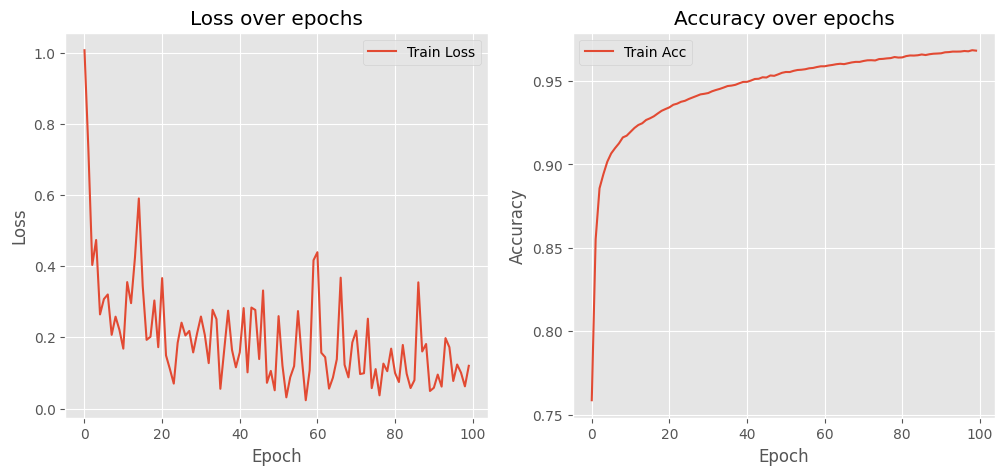

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Accuracy function
# ----------------------------
def compute_accuracy(layers, X, Y_true):
    A = X.T  # shape (features, batch)
    for layer in layers:
        A = layer.forward(A)
    y_pred = np.argmax(A, axis=0)
    y_true = np.argmax(Y_true, axis=0)
    acc = np.mean(y_pred == y_true)
    return acc

# ----------------------------
# Modified training loop
# ----------------------------
def train_plot(X, Y, layers, loss_fn, optimizer, epochs=5, batch_size=64, X_val=None, Y_val=None):
    m = X.shape[0]
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        perm = np.random.permutation(m)
        X_shuffled = X[perm].T  # (features, batch)
        Y_shuffled = Y[:, perm]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]

            # Forward pass
            A = X_batch
            for layer in layers:
                A = layer.forward(A)

            # Compute loss
            loss = loss_fn.forward(A, Y_batch)

            # Backward pass
            dA = loss_fn.backward(A, Y_batch)
            for layer in reversed(layers):
                dA, dW, db = layer.backward(dA)
                optimizer.update(layer, dW, db)

        # Record metrics at the end of the epoch
        train_acc = compute_accuracy(layers, X, Y)
        history['loss'].append(loss)
        history['accuracy'].append(train_acc)

        if X_val is not None and Y_val is not None:
            # Validation metrics
            val_loss = loss_fn.forward(forward_pass(X_val.T, layers), Y_val)
            val_acc = compute_accuracy(layers, X_val, Y_val)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Acc: {train_acc:.4f}")
        
        # Log metrics to wandb
        wandb.log({
            "train_loss": loss,
            "train_acc": train_acc,
            "val_loss": val_loss if X_val is not None else None,
            "val_acc": val_acc if X_val is not None else None,
            "epoch": epoch + 1
        })


    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='Train Loss')
    if X_val is not None:
        plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='Train Acc')
    if X_val is not None:
        plt.plot(history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.show()

    return history

# ----------------------------
# Helper: forward pass
# ----------------------------
def forward_pass(X_T, layers):
    A = X_T
    for layer in layers:
        A = layer.forward(A)
    return A

# ----------------------------
# Example usage
# ----------------------------

# Define network
layers = [
    DenseLayer(X_train.shape[1], 20, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(20, 10, activation=Softmax(), initializer=NormalInitializer(mean=0, std=0.01))
]

# Optimizer
opt = SGD(learning_rate=wandb.config.learning_rate)

# Train and plot
history = train_plot(X_train, Y_train, layers, CrossEntropyLoss(), opt, epochs=wandb.config.epochs, batch_size=wandb.config.batch_size)